In [23]:
import pandas as pd
import numpy as np
import re
from typing import List
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from sklearn.utils import resample

In [24]:
def merge_data(_df_list: List[pd.DataFrame]) -> pd.DataFrame:
    """
    merges the dataframes according to their primary/foreign keys
    :param _df_list: list of dataframes to be merged
    :return: the merged dataframe
    """
    # set up internal parameters
    suffixes = ['_1', '_2']
    r = re.compile('\w*Id')

    # set up variables based on input
    num = len(_df_list)  # length of the list
    to_select = list(range(1,num))  # list of indexes of dataframe to be merged
    remaining = set(range(1,num))  # set of remaining indexes of dataframes yet to be merged

    # get all the '<something>id' columns for each dataframe
    id_list = [set(filter(r.match, table)) for table in _df_list]
    # set up the merged dataframe, 'mg_df'
    mg_df = _df_list[0]
    mg_id = id_list[0]  # set the id set of the merged dataframe as the first dataframe's id set

    # start merging dataframes
    while True:
        merge_flag = 0  # flag indicating if a while-true run has merged any new dataframe
        for index in to_select:
            intersect = mg_id.intersection(id_list[index])
            all_col_intersect = set(mg_df.columns).intersection(set(_df_list[index].columns))
            # iterate through the remaining dataframe
            # and merge those with common id(s)
            if (index in remaining) and intersect:
                if all_col_intersect == intersect:
                    mg_df = pd.merge(mg_df, _df_list[index], on=list(intersect), how='left')
                else:
                    # if there are other common columns than the ids, set suffixes
                    mg_df = pd.merge(mg_df, _df_list[index], on=list(intersect), how='left', suffixes=suffixes)
                # add the new ids into the total id set of the merged dataframe
                mg_id = mg_id.union(set(id_list[index]))
                remaining.remove(index)  # remove the index of the added dataframe
                merge_flag = 1
        if not remaining:
            break  # break if there is no more dataframe to be added
        if not merge_flag:  # if no new dataframe was merged in this while-true run
            print('Error: no common "id" columns found')
            break  # breaks
    return mg_df


def process_laps_stops(mg_df: pd.DataFrame) -> pd.DataFrame:
    _total_laps = mg_df[(mg_df['positionOrder'] == 1) & (mg_df['stop'] == 1)].reset_index(drop=True)[['raceId', 'laps']]
    _total_laps.columns = [str(_total_laps.columns[0]), 'total_laps']
    _total_stops = mg_df.groupby(by=['raceId', 'driverId'], as_index=False)['stop'].max()
    _total_stops.columns = list(_total_stops.columns[:2]) + ['total_stops']

    mg_df = pd.merge(mg_df, _total_laps, on='raceId')
    mg_df = pd.merge(mg_df, _total_stops, on=['raceId', 'driverId'])
    mg_df['lap_prop'] = mg_df.apply(lambda x: x['lap']/x['total_laps'], axis=1)
    mg_df['abs_err'] = mg_df.apply(lambda x: abs(x['stop']/(x['total_stops']+1) - x['lap_prop']), axis=1)
    return mg_df


def get_err_mean(mg_df: pd.DataFrame):
    avg_err = pd.DataFrame(mg_df.groupby(['raceId', 'driverId'])['abs_err'].mean())
    avg_err = avg_err.add_suffix('_mean').reset_index()
    select_columns = ['raceId', 'driverId', 'positionOrder', 'abs_err_mean']
    test_df = mg_df.merge(avg_err, on=['raceId', 'driverId'])[select_columns]
    test_df = test_df.drop_duplicates()
    top_number = 5
    _df_front = test_df[test_df['positionOrder'] <= top_number]['abs_err_mean']
    _df_back = test_df[test_df['positionOrder'] > top_number]['abs_err_mean']
    return _df_front, _df_back


def group_by_stop_num(df: pd.DataFrame) -> dict:
    pit_stop_max = df['total_stops'].max()
    _df_dict = {}
    for i in range(1, pit_stop_max+1):
        _df_dict[i] = df[df['total_stops']==i][['stop','lap_prop']]
    return _df_dict


def df_to_list(mg_df: pd.DataFrame, select_col='lap_prop', max_pit = 3, top_num = 5):
    df_front = []
    df_back = []
    for i in range(1, max_pit+1):
        df_tmp = mg_df[mg_df['total_stops']==i]
        for j in range(1, i+1):
            df_select = df_tmp[df_tmp['stop']==j]
            df_front.append(df_select[df_select['positionOrder'] <= top_num][['stop', select_col]])
            df_back.append(df_select[df_select['positionOrder'] > top_num][['stop', select_col]])
    return df_front, df_back


def comparison_plot(list_1: [pd.DataFrame], list_2: [pd.DataFrame], select_col='lap_prop',
                    show_mean=True, show_description=True, divide=True, non_para=False, save_fig=False):
    """
    d
    :param non_para:
    :param divide:
    :param select_col:
    :param list_1:
    :param list_2:
    :param save_fig:
    :param show_description:
    :param show_mean:
    :return:
    """
    bins = np.linspace(0,1,50)
    color_bin = ['tab:blue', 'tab:orange', 'tab:red']
    color_bin2 = ['deepskyblue', 'crimson', 'lavender']

    plot_index = [[1,1], [2,1], [2,2], [3,1], [3,2], [3,3]]
    plot_num = 6

    for _i in range(plot_num):
        _total = plot_index[_i][0]  # total pit stops
        _pit = plot_index[_i][1]  # pit stop number
        df_f = list_1[_i][select_col]  # front
        df_b = resample(list_2[_i][select_col],
                        replace=True, n_samples=len(df_f), random_state=123)  # back

        plt.figure(figsize=(12,6))
        plt.hist(df_b, bins, alpha=0.8, color=color_bin[2])
        plt.hist(df_f, bins, alpha=0.8, color=color_bin[0])

        df_f_mean = round(df_f.mean(), ndigits=3)
        df_b_mean = round(df_b.mean(), ndigits=3)
        if show_mean:
            plt.axvline(x=df_f_mean, color=color_bin2[0], linewidth=4)
            plt.axvline(x=df_b_mean, color=color_bin2[1], linewidth=4)
            if divide: plt.axvline(x=_pit/(_total+1), color='gold', linewidth=4)
        if show_description:
            if not non_para:
                p_value = ttest_ind(df_f, df_b).pvalue
            else:
                p_value = mannwhitneyu(df_f, df_b).pvalue
            print(f'Total Pits: {_total}, no.{_pit} pit, p value={p_value}')

        if save_fig: plt.savefig(f'image/hypo3/distribution_{_total}_{_pit}.png', transparent=False)
        plt.show()


def err_mean_plot(_df_front: pd.DataFrame, _df_back: pd.DataFrame, save_fig=False):
    df_f = _df_front
    df_b = resample(_df_back, replace=True, n_samples=len(df_f), random_state=123)

    bins = np.linspace(0,1,50)
    color_bin = ['tab:blue', 'tab:orange', 'tab:red']
    color_bin2 = ['deepskyblue', 'crimson', 'lavender']

    plt.figure(figsize=(12,6))
    plt.hist(df_b, bins, alpha=0.8, color=color_bin[2])
    plt.hist(df_f, bins, alpha=0.8, color=color_bin[0])

    df_f_mean = round(df_f.mean(), ndigits=3)
    df_b_mean = round(df_b.mean(), ndigits=3)

    plt.axvline(x=df_f_mean, color=color_bin2[0], linewidth=4)
    plt.axvline(x=df_b_mean, color=color_bin2[1], linewidth=4)

    p_value = mannwhitneyu(df_f, df_b).pvalue
    print(f'Mann-Whitney U rank test p value={p_value}')

    if save_fig: plt.savefig(f'image/hypo3/err_mean.png', transparent=False)
    plt.show()

In [25]:
# Load data
pit = pd.read_csv('data/pit_stops.csv')
results = pd.read_csv('data/results.csv')
status = pd.read_csv('data/status.csv')

In [26]:
# Process the data files
merge_df = merge_data([pit, results, status])
merge_df = process_laps_stops(merge_df)

Total Pits: 1, no.1 pit, p value=0.030645675472496137


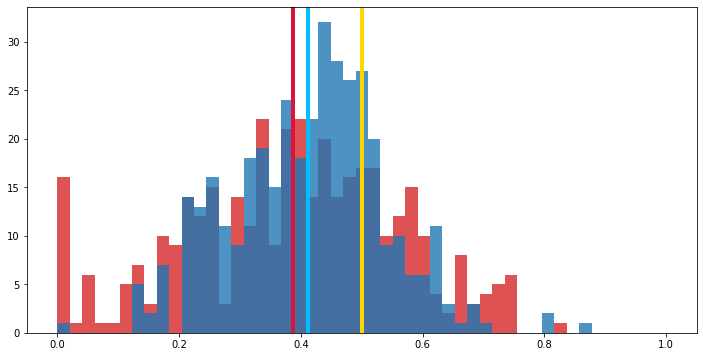

Total Pits: 2, no.1 pit, p value=0.0005814598616683752


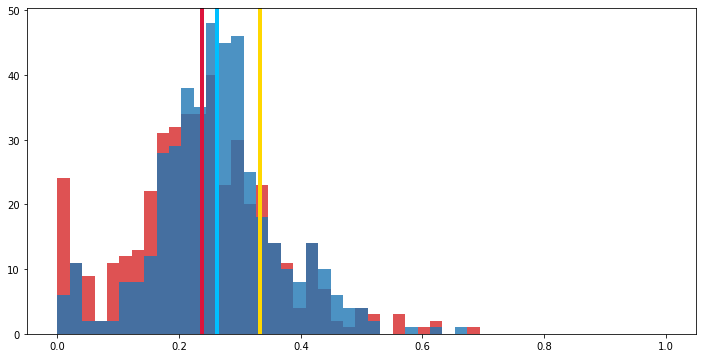

Total Pits: 2, no.2 pit, p value=0.0010307002970602064


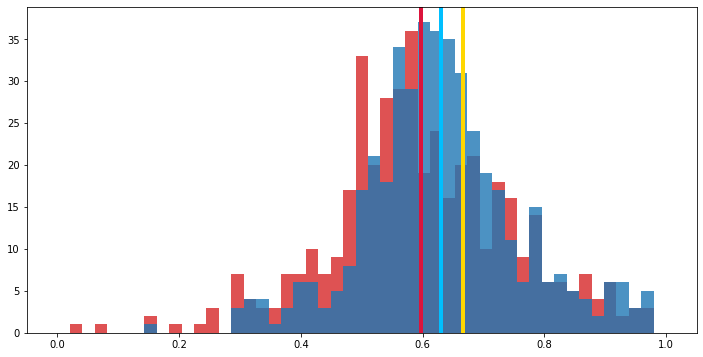

Total Pits: 3, no.1 pit, p value=0.1956243657495232


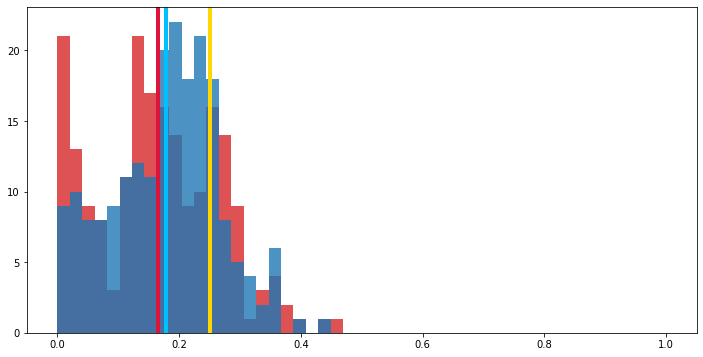

Total Pits: 3, no.2 pit, p value=0.005606751461095249


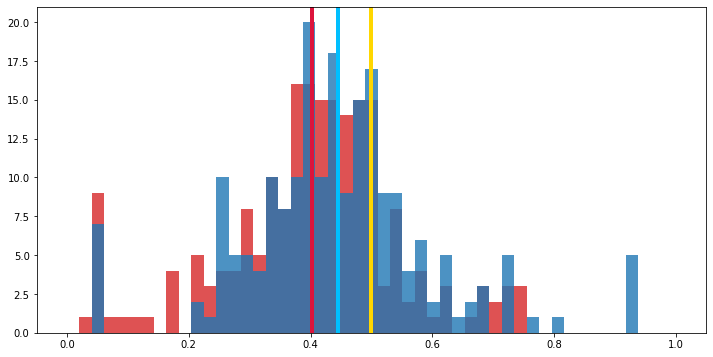

Total Pits: 3, no.3 pit, p value=0.0013851020042062255


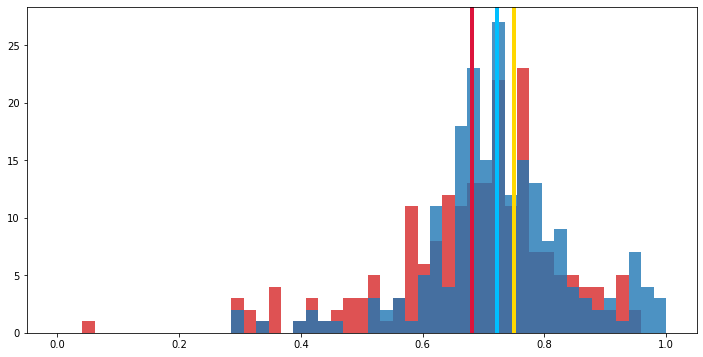

In [27]:
# Show Results
df_front, df_back = df_to_list(merge_df) # top 5
comparison_plot(df_front, df_back, save_fig=True)

Total Pits: 1, no.1 pit, p value=6.238180473135758e-06


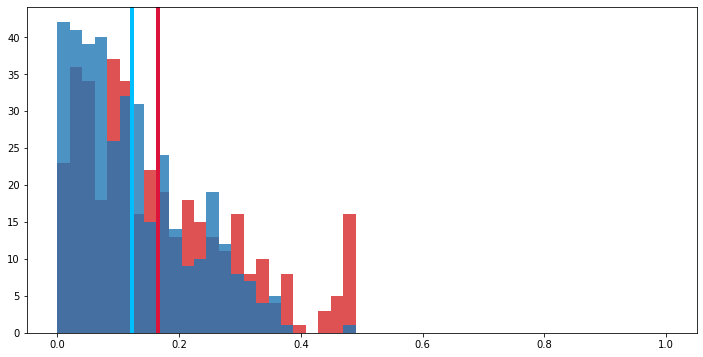

Total Pits: 2, no.1 pit, p value=3.779041945496054e-05


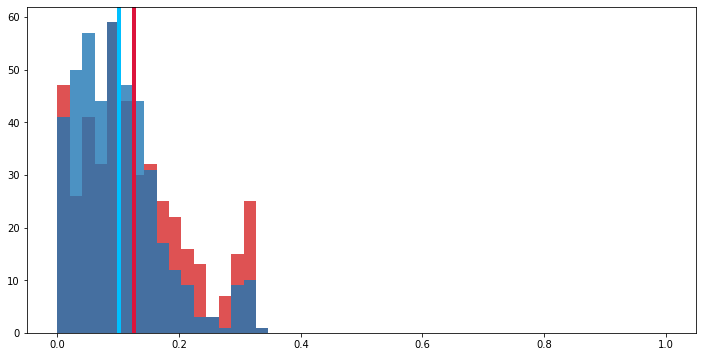

Total Pits: 2, no.2 pit, p value=1.6127403046234223e-06


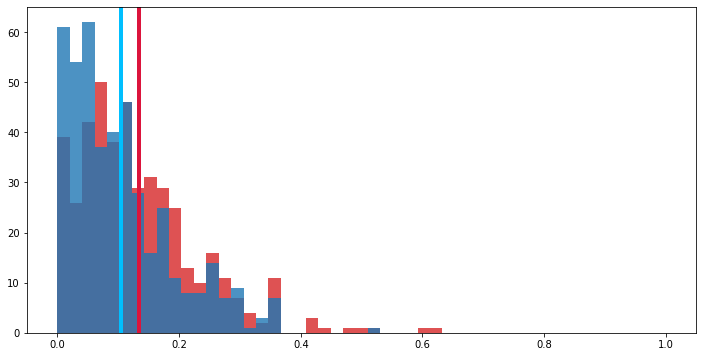

Total Pits: 3, no.1 pit, p value=0.012617489999057973


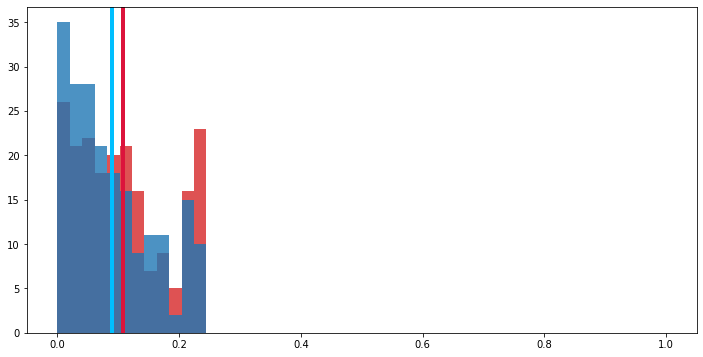

Total Pits: 3, no.2 pit, p value=0.2617396560815619


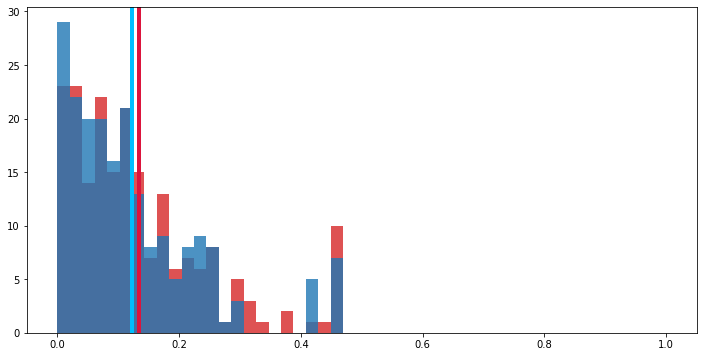

Total Pits: 3, no.3 pit, p value=0.1653740228092856


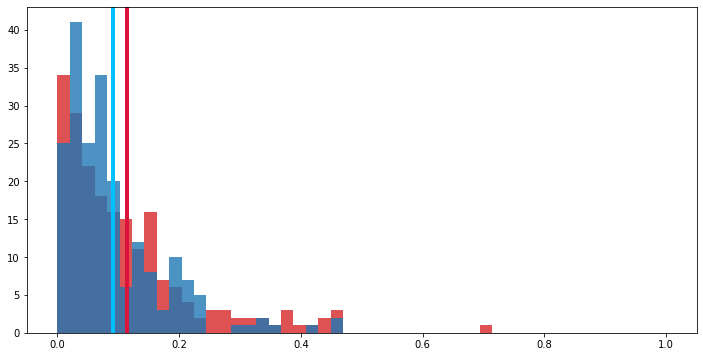

In [28]:
df_front, df_back = df_to_list(merge_df, select_col='abs_err')
comparison_plot(df_front,df_back, select_col='abs_err', divide=False, non_para=True)

In [29]:
df_front, df_back = get_err_mean(merge_df)

Mann-Whitney U rank test p value=7.145989150204431e-09


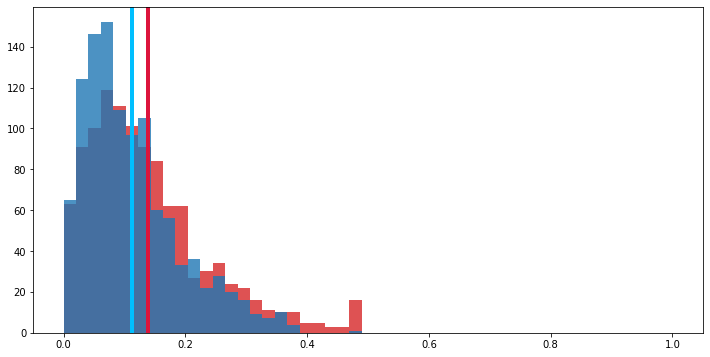

In [30]:
err_mean_plot(df_front,df_back, save_fig=True)